# Testing of OCDFG Streaming Discovery

{'type': 'aer_diagram', 'model': {'Create Transport Document': {('Customer Order', 'Transport Document'): 'ONE_TO_ONE'}, 'Book Vehicles': {('Transport Document', 'Vehicle'): 'ONE_TO_MANY'}, 'Order Empty Containers': {('Container', 'Transport Document'): 'MANY_TO_ONE'}}}
{'type': 'aer_diagram', 'model': {'Create Transport Document': {('Customer Order', 'Transport Document'): 'ONE_TO_ONE'}, 'Book Vehicles': {('Transport Document', 'Vehicle'): 'ONE_TO_MANY'}, 'Order Empty Containers': {('Container', 'Transport Document'): 'MANY_TO_ONE'}}}
{'type': 'aer_diagram', 'model': {'Create Transport Document': {('Customer Order', 'Transport Document'): 'ONE_TO_ONE'}, 'Book Vehicles': {('Transport Document', 'Vehicle'): 'ONE_TO_MANY'}, 'Order Empty Containers': {('Container', 'Transport Document'): 'MANY_TO_ONE'}, 'Load Truck': {('Container', 'Handling Unit'): 'ONE_TO_ONE', ('Container', 'Truck'): 'ONE_TO_ONE', ('Handling Unit', 'Truck'): 'ONE_TO_ONE'}}}
{'type': 'model', 'object_type': 'Handling Un

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



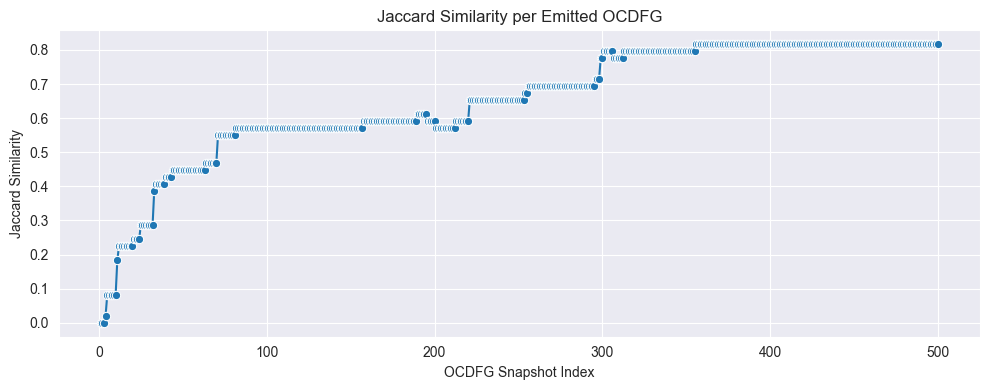

In [1]:
from pybeamline.algorithms.oc.oc_merge_operator import oc_merge_operator
import importlib
import pybeamline
from pybeamline.algorithms.oc.oc_operator import oc_operator
importlib.reload(pybeamline)
from typing import Tuple, List, Any, Dict
from pybeamline.objects.ocdfg import OCDFG
from pybeamline.sources.ocel_log_source_from_file import ocel_log_source_from_file
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery
from pm4py.read import read_ocel2_json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Path to the OCEL2 log file
log_path = '../../tests/logistics.jsonocel'

# PM4Py
def read_ocel2_log(filename: str):
    return read_ocel2_json(filename)

# Load the OCEL log
oc_event_log = read_ocel2_log(log_path)
assert oc_event_log is not None

# Do OCDFG static discovery
ocdfg = ocdfg_discovery.apply(oc_event_log)
def conform_ocdfg(ocdfg_pm4py) -> set[Tuple[str, str, str]]:
    """
    Convert PM4Py OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type in ocdfg_pm4py["edges"]["event_couples"].keys():
        for src, tgt in ocdfg_pm4py["edges"]["event_couples"][obj_type].keys():
            result.add((src, obj_type, tgt))
    return result
# Convert the PM4Py OCDFG to a set of edges
ocdfg_edges_pm4py = conform_ocdfg(ocdfg)


# Create source from file
source = ocel_log_source_from_file(log_path)

# Set based jaccard similarity function
def jaccard_similarity(model: set, ref_model: set) -> float:
    intersection = model.intersection(ref_model)
    #if intersection is not None:
    #    print(f"The missing edges in the model: {ref_model - intersection}")
    intersection = len(model.intersection(ref_model))
    union = len(model.union(ref_model))

    if union == 0:
        return 0.0
    return intersection / union

emitted_ocdfgs = []
def append_ocdfg(output):
    global emitted_ocdfgs
    emitted_ocdfgs.append(output["ocdfg"])


source.pipe(
    oc_operator(),
    oc_merge_operator()
).subscribe(append_ocdfg)


# Conform the emitted OCDFGs to the set notation of edges
def conform_emit_ocdfg(ocdfg: OCDFG) -> set[tuple[str, str, str]]:
    """
    Convert OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type, transitions in ocdfg.edges.items():
        for (src, tgt), freq in transitions.items():
            result.add((src, obj_type, tgt))
    return result

emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for ocdfg_edge_set in emitted_ocdfgs_edge_set:
    similarity = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append(similarity)


# Create a DataFrame for Seaborn
df = pd.DataFrame({
    "Snapshot": range(1, len(jacc_similarities) + 1),
    "Jaccard Similarity": jacc_similarities
})

# Plot
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="Snapshot", y="Jaccard Similarity", marker="o")
plt.title("Jaccard Similarity per Emitted OCDFG")
plt.xlabel("OCDFG Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

jacc_sim_slice = jacc_similarities[:500]  # Display the first 500 similarities for brevity
df_slice = pd.DataFrame({
    "Snapshot": range(1, len(jacc_sim_slice) + 1),
    "Jaccard Similarity": jacc_sim_slice
})

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_slice, x="Snapshot", y="Jaccard Similarity", marker="o")
plt.title("Jaccard Similarity per Emitted OCDFG")
plt.xlabel("OCDFG Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()




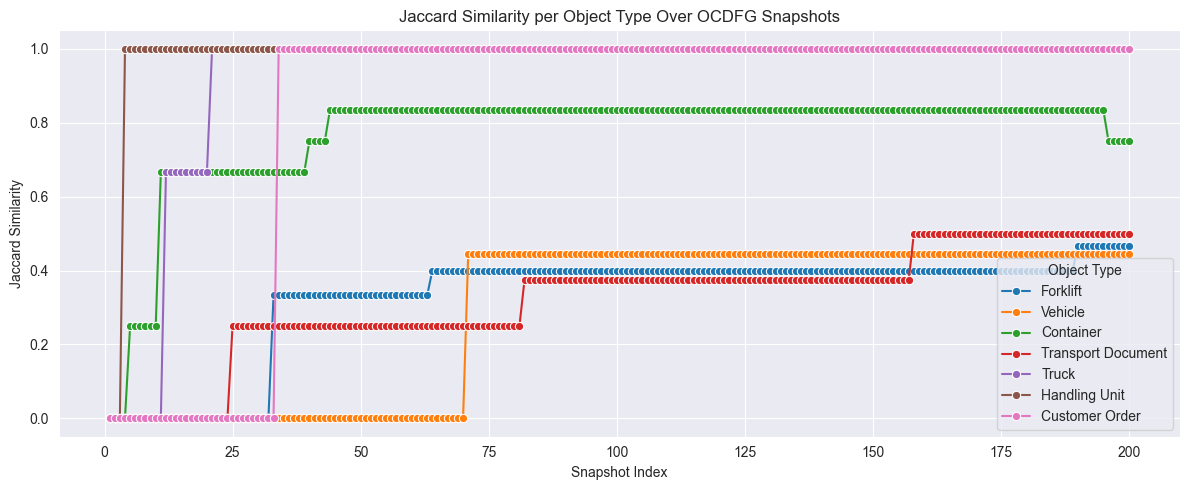

In [2]:

def egdes_pr_object_type(ocdfg: set[Tuple[str,str,str]]) -> Dict[str, set[Tuple[str, str, str]]]:
    """
    Convert OCDFG to a dictionary of edges per object type.
    """
    result = {}
    for src, obj_type, tgt in ocdfg:
        if obj_type not in result:
            result[obj_type] = set()
        result[obj_type].add((src,obj_type, tgt))
    return result

# Convert the PM4Py OCDFG edges to a dictionary of edges per object type
ocdfg_edges_per_object_type = egdes_pr_object_type(ocdfg_edges_pm4py)

emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

obj_type_jacc_similarities = {}

for snapshot in emitted_ocdfgs_edge_set:
    snapshot_per_obj = egdes_pr_object_type(snapshot)

    for obj_type, ref_edges in ocdfg_edges_per_object_type.items():
        # Initialize list if first time
        if obj_type not in obj_type_jacc_similarities:
            obj_type_jacc_similarities[obj_type] = []

        model_edges = snapshot_per_obj.get(obj_type, set())
        similarity = jaccard_similarity(model_edges, ref_edges)
        obj_type_jacc_similarities[obj_type].append(similarity)

records = []

for obj_type, similarities in obj_type_jacc_similarities.items():
    for i, sim in enumerate(similarities[:200], start=1):
        records.append({
            "Snapshot": i,
            "Object Type": obj_type,
            "Jaccard Similarity": sim
        })

df_long = pd.DataFrame(records)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_long, x="Snapshot", y="Jaccard Similarity", hue="Object Type", marker="o")
plt.title("Jaccard Similarity per Object Type Over OCDFG Snapshots")
plt.xlabel("Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

